# Panoptic Segmentation Inference

### Set Proxy Environment Variables

In [1]:
import os

# Set proxy environment variables
os.environ['http_proxy'] = 'http://proxy:80'
os.environ['https_proxy'] = 'http://proxy:80'

### Import Required Libraries

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision import models
from torchvision.models.segmentation import fcn_resnet50
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torchvision.transforms import functional as F
from matplotlib.colors import ListedColormap
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import random

### Load Instance and Semantic Model

In [3]:
def get_model_instance_segmentation(num_classes):
    weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
    model = models.detection.maskrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

def load_model(model_path, num_classes, device):
    model = get_model_instance_segmentation(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def load_fcn_model(model_path, num_classes, device):
    model = fcn_resnet50(weights=None, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path), strict=False)
    model.eval().to(device)
    return model

### Define Inference for Instance and Semantic Models

In [4]:
def run_instance_inference(model, device, image_path, threshold=0.5):
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    img = Image.open(image_path).convert("RGB")
    img = np.array(img)
    transformed = transform(image=img)
    img_tensor = transformed['image']
    img_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_masks = prediction[0]['masks'].cpu().numpy()
    pred_boxes = pred_boxes[pred_scores >= threshold]
    pred_masks = pred_masks[pred_scores >= threshold]
    pred_scores = pred_scores[pred_scores >= threshold]
    return img, pred_boxes, pred_masks, pred_scores


def run_semantic_inference(model, device, image_path):
    input_image = Image.open(image_path)
    image = F.to_tensor(input_image.convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)['out']
    semantic_mask_bin = (torch.sigmoid(output).squeeze().cpu().numpy() > 0.1).astype(np.uint8)
    return input_image, semantic_mask_bin

### Combine and Visualize Results

In [5]:
def random_color():
    return [random.randint(0, 255) for _ in range(3)]

def create_panoptic_mask_with_colors(instance_masks, semantic_mask, scores, threshold=0.1):
    height, width = semantic_mask.shape
    panoptic_mask = np.zeros((height, width, 3), dtype=np.uint8)
    semantic_mask_bin = (semantic_mask > threshold).astype(np.uint8)
    panoptic_mask[:] = (0, 0, 0)
    panoptic_mask[semantic_mask_bin == 1] = (0, 255, 0)
    
    current_label = 2
    for idx, (mask, score) in enumerate(zip(instance_masks, scores)):
        if score > threshold:
            mask_bin = mask.squeeze() > threshold
            unique_color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
            panoptic_mask[mask_bin] = unique_color
            contours, _ = cv2.findContours(mask_bin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(panoptic_mask, contours, -1, (255, 0, 0), 1)
            current_label += 1
    return panoptic_mask

def plot_panoptic_results(input_image, spine_path, dendrite_path, panoptic_mask):
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 4, 1)   
    plt.imshow(Image.open(input_image))
    plt.title('Input Image')
    plt.axis('off')

    mask = Image.open(spine_path).convert('L')
    binary_mask = mask.point(lambda p: p > 0 and 255)
    plt.subplot(1, 4, 2)
    plt.imshow(binary_mask, cmap='gray', vmin=0, vmax=255)
    plt.title('Spine Mask')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(Image.open(dendrite_path))
    plt.title('Dendrite Mask')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(panoptic_mask)
    plt.title('Panoptic Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### Run Panoptic Inference

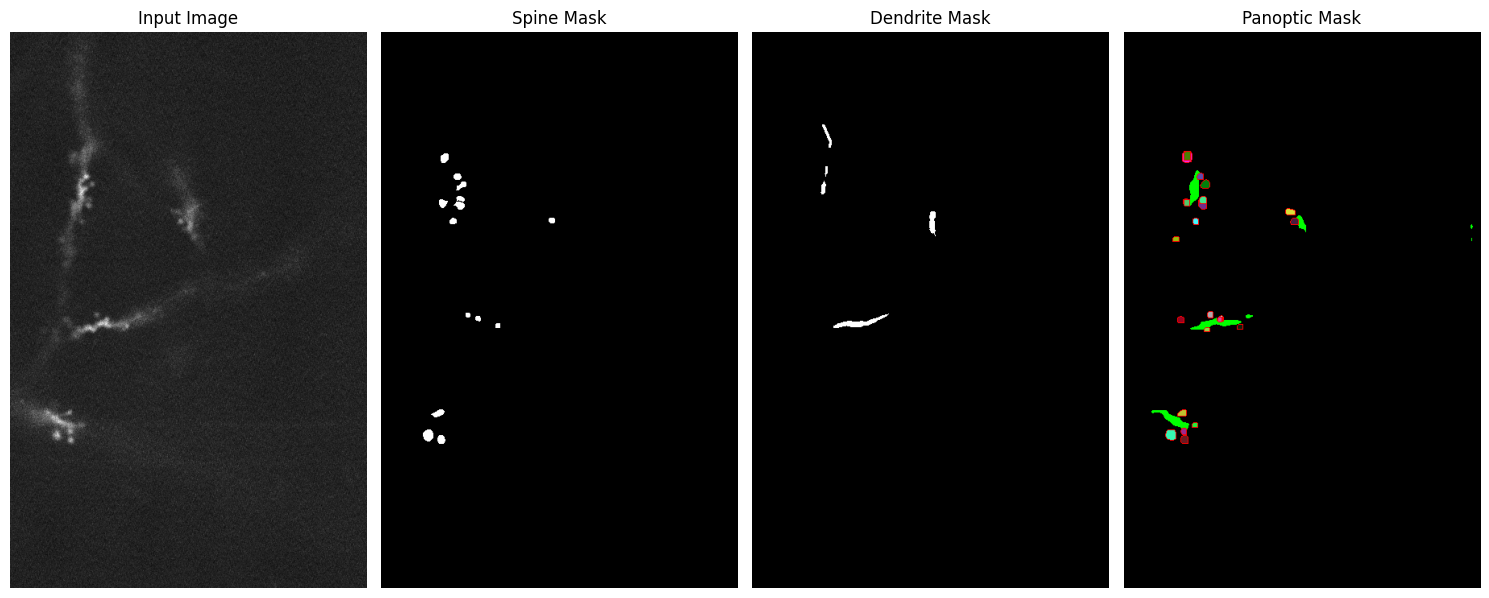

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes_instance = 2
num_classes_semantic = 1

model_instance = load_model('spines_model.pt', num_classes_instance, device)
model_semantic = load_fcn_model('dendrite_model.pt', num_classes_semantic, device)

idx = 90
dset = 'Training'

image_path = f'Dataset/DeepD3_{dset}/input_images/image_{idx}.png'
dendrite_path = f'Dataset/DeepD3_{dset}/dendrite_images/dendrite_{idx}.png'
spine_path = f'Dataset/DeepD3_{dset}/spine_images/spine_{idx}.png'

img, boxes, instance_masks, scores = run_instance_inference(model_instance, device, image_path, threshold=0)
input_image, semantic_mask = run_semantic_inference(model_semantic, device, image_path)

panoptic_mask = create_panoptic_mask_with_colors(instance_masks, semantic_mask, scores, threshold=0.3)
plot_panoptic_results(image_path, spine_path, dendrite_path, panoptic_mask)

### End of Script